# Analysis of Training Files

1. Do the test set and train set come from the same project?
2. How clean is the dataset? Is it script only? Is it coded by professionals with same style? Or mixed?

for test set vs validation set?

how many are class based / function based / both?

how many are inline code vs modular?

inline variable definition?

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# search training files
train_file_dir = 'train_files'
train_file_list = os.listdir(train_file_dir)

file_count = 0
for fp in train_file_list:
    if os.path.splitext(fp)[1].lower() != '.py':
        raise ValueError(f'unknown file! {fp}')
    file_count += 1

df_train = pd.DataFrame(train_file_list, columns=[
    'filename'
])
df_train = df_train.reset_index()

print(f'found {len(df_train)} train files')

# search test files
test_file_dir = 'test_files'
test_file_list = os.listdir(test_file_dir)

file_count = 0
for fp in test_file_list:
    if os.path.splitext(fp)[1].lower() != '.py':
        raise ValueError(f'unknown file! {fp}')
    file_count += 1

df_test = pd.DataFrame(test_file_list, columns=[
    'filename'
])
df_test = df_test.reset_index()
print(f'found {len(df_test)} test files')

found 10000 train files
found 50 test files


In [2]:
def load_stats(df, files_dir):
    filenames = df['filename']
    # load line count
    non_empty_line_count = {}
    is_init = {}
    root_class_count = {}
    root_function_count = {}

    for fn in filenames:
        try:
            with open(os.path.join(files_dir, fn), 'r', encoding='utf-8', errors='ignore') as f :
                lines = f.readlines()
                lines = [l.strip('\n') for l in lines]
                lines = [l for l in lines if len(l.strip()) > 0]
                non_empty_line_count[fn] = len(lines)

                curr_is_init = '__init__.py' == fn[-1 * len('__init__.py'):]
                is_init[fn] = curr_is_init

                curr_root_class_count = len([l for l in lines if l[:len('class')] == 'class'])
                root_class_count[fn] = curr_root_class_count

                curr_root_function_count = len([l for l in lines if l[:len('def')] == 'def'])
                root_function_count[fn] = curr_root_function_count

        except Exception as e:
            print(fn)
            raise e

    df['non_empty_line_count'] = non_empty_line_count.values()
    df['is_init'] = is_init.values()
    df['root_class_count'] = root_class_count.values()
    df['root_function_count'] = root_function_count.values()
    
load_stats(df_test, test_file_dir)
load_stats(df_train, train_file_dir)

In [3]:
df_train.head()

,index,filename,non_empty_line_count,is_init,root_class_count,root_function_count
0,0,data_alan-hicks_django-dmarc_docs_conf.py,196,False,0,0
1,1,data_QingdaoU_OnlineJudge_utils_management_com...,17,False,1,0
2,2,data_all-umass_metric-learn_metric_learn_lsml.py,118,False,1,1
3,3,data_goodfeli_adversarial_parzen_ll.py,123,False,0,7
4,4,data_anhstudios_swganh_data_scripts_templates_...,12,False,0,1


In [4]:
df_test.head()

,index,filename,non_empty_line_count,is_init,root_class_count,root_function_count
0,0,data_ImageEngine_gaffer_python_GafferCortexUI_...,45,False,1,0
1,1,data_HewlettPackard_python-ilorest-library_src...,1829,False,17,0
2,2,data_Havate_havate-openstack_proto-build_gui_h...,31,False,3,0
3,3,data_ImageEngine_gaffer_python_GafferCortexTes...,59,False,1,0
4,4,data_IanLewis_django-lifestream_lifestream_rss.py,27,False,1,0


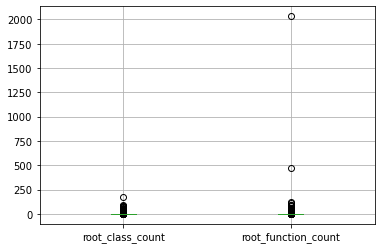

In [5]:
df_train.boxplot(column=['root_class_count', 'root_function_count'])

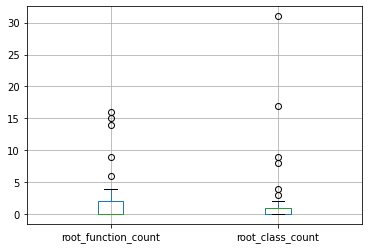

In [6]:
df_test.boxplot(column=['root_function_count', 'root_class_count'])

In [7]:
df_train.loc[df_train['root_class_count'].idxmax()]

index                                                                8440
filename                data_francelabs_datafari_windows_python_Lib_te...
non_empty_line_count                                                 3884
is_init                                                             False
root_class_count                                                      176
root_function_count                                                     2
Name: 8440, dtype: object

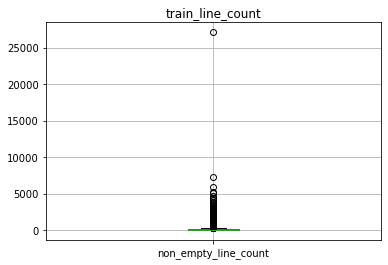

In [8]:
df_train.boxplot(column=['non_empty_line_count'])
plt.title('train_line_count')
plt.show()

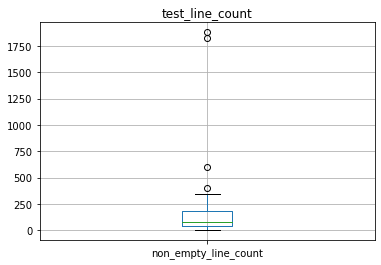

In [9]:
df_test.boxplot(column=['non_empty_line_count'])
plt.title('test_line_count')
plt.show()

In [10]:
df_test.loc[df_test['non_empty_line_count'].idxmax()]

index                                                                  49
filename                data_IanLewis_kay_kay_lib_werkzeug_datastructu...
non_empty_line_count                                                 1878
is_init                                                             False
root_class_count                                                       31
root_function_count                                                     4
Name: 49, dtype: object

In [11]:
df_train.loc[df_train['non_empty_line_count'].idxmax()]

index                                                                3618
filename                data_openstack_proliantutils_proliantutils_tes...
non_empty_line_count                                                27112
is_init                                                             False
root_class_count                                                        0
root_function_count                                                     0
Name: 3618, dtype: object

In [12]:
def parse_import_files(file_list, file_dir):
    
    # parse_import('import hello as hi') = ['hello']
    # parse_import('from matplotlib import plt as plt') = ['matplotlib']
    # parse_import('import jank, james') = ['jank', 'james']
    # parse_import('import time') = ['time']
    # parse_import('') = []        
    # parse_import('not import') = []
    def parse_import(line):
        if line[:len('import')] != 'import' and not line[:len('from')] == 'from':
            return []

        line = line.strip()
        params = line.split()
        params = params[1:]

        imports = []
    
        for p in params:
            p = p.strip()
            has_more = p[-1] == ','

            if not has_more:
                imports.append(p)
                break
            else:
                imports.append(p.strip(','))
    
        return imports

    import_names = {}

    for fn in file_list:
        with open(os.path.join(file_dir, fn), 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
            for line in lines:
                imports = parse_import(line)
                if len(imports) > 0:
                    for name in imports:
                        count = import_names.get(name, 0)
                        count += 1
                        import_names[name] = count
                        
    return import_names

train_imports = parse_import_files(df_train['filename'], train_file_dir)
test_imports = parse_import_files(df_test['filename'], test_file_dir)

def create_import_df(import_dict):
    data = [[key, import_dict[key]] for key in import_dict.keys()]
    return pd.DataFrame(data, columns=['import', 'count'])

df_train_imports = create_import_df(train_imports).sort_values(by='count', ascending=False)
df_test_imports = create_import_df(test_imports).sort_values(by='count', ascending=False)

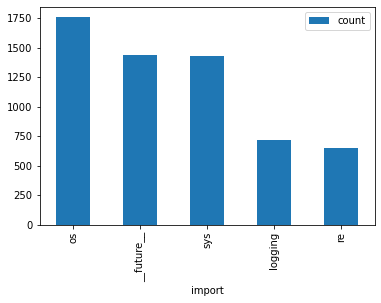

In [13]:
df_train_imports[:5].plot.bar(x='import')

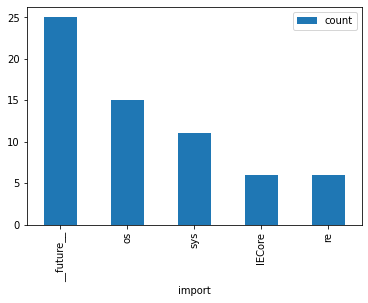

In [14]:
df_test_imports[:5].plot.bar(x='import')

In [15]:
inline_count = 0
module_count = 0

import io, tokenize, re
def remove_comments_and_docstrings(source):
    io_obj = io.StringIO(source)
    out = ""
    prev_toktype = tokenize.INDENT
    last_lineno = -1
    last_col = 0
    for tok in tokenize.generate_tokens(io_obj.readline):
        
        # ignore lines that doesnt have code in first indent
        is_root_line = len(tok.line) > 0 and tok.line[0] != ' '
        
        if not is_root_line:
            continue
        
        token_type = tok[0]
        token_string = tok[1]
        start_line, start_col = tok[2]
        end_line, end_col = tok[3]
        ltext = tok[4]
        if start_line > last_lineno:
            last_col = 0
        if start_col > last_col:
            out += (" " * (start_col - last_col))
        if token_type == tokenize.COMMENT:
            pass
        elif token_type == tokenize.STRING:
            if prev_toktype != tokenize.INDENT:
                if prev_toktype != tokenize.NEWLINE:
                    if start_col > 0:
                        out += token_string
        else:
            out += token_string
        prev_toktype = token_type
        last_col = end_col
        
    return [l.strip() for l in out.splitlines() if l.strip()]


def parse_runnable_files(file_list, file_dir):
    
    files_is_inline_list = []
    
    for fn in file_list:
        
        with open(os.path.join(file_dir, fn), 'r', encoding='utf-8', errors='ignore') as f:
            
            lines = remove_comments_and_docstrings(f.read())
            
            is_inline = False
            
            for line in lines:
                
                def check_inline(line) -> bool:
                    
                    is_root = line[0] != ' '

                    if not is_root:
                        return False

                    line = line.strip()
                    params = line.split()
                    params = [p.strip() for p in params]

                    if len(params) < 2:
                        return False

                    # skip value assignments
                    if '=' in params:
                        return False

                    first = params[0]

                    # skip @
                    if '@' == first:
                        return False

                    # template {%
                    if '{%' == first:
                        return False

                    if first[0] in ['}', '{', '[', ']', '<', '>']:
                        return False

                    if params[0] in ['class', 'def', 'import', 'from']:
                        return False
                    
                    return True
                    
                if check_inline(line):
                    is_inline = True
                    break
                    
            files_is_inline_list.append([fn, is_inline])
            
    return files_is_inline_list
                    


In [16]:
files_is_inline_list = parse_runnable_files(df_train['filename'], train_file_dir)
df_train_inline = pd.DataFrame(files_is_inline_list, columns=['filename', 'is_inline'])

In [17]:
files_is_inline_list = parse_runnable_files(df_test['filename'], test_file_dir)
df_test_inline = pd.DataFrame(files_is_inline_list, columns=['filename', 'is_inline'])

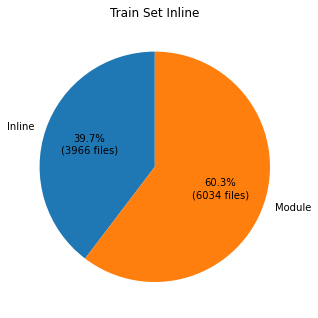

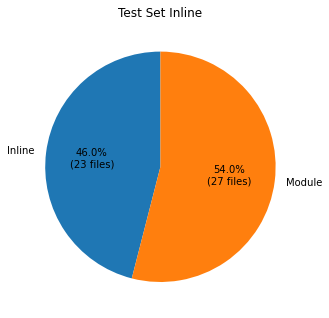

In [18]:
def plot_inline(df, title):
    
    df_inline_true = df[df['is_inline'] == True]
    df_inline_false = df[df['is_inline'] == False]
    
    data = [len(df_inline_true), len(df_inline_false)]
    labels = ['Inline', 'Module']
    
    def fmt_label(pct, count):
        absolute = round(pct / 100.0 * count, 1)
        return "{:1.1f}%\n({:.0f} files)".format(pct, absolute)

    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])
    ax.set_title(title)
    ax.pie(data,labels=labels,
            shadow=False, startangle=90, autopct=lambda pct: fmt_label(pct, len(df)))

    fig.savefig(f'{title}.png', figsize=(4, 4), dpi=200, bbox_inches='tight')
    
plot_inline(df_train_inline, 'Train Set Inline')
plot_inline(df_test_inline, 'Test Set Inline')

In [19]:
# add module|inline info - train
df_train_inline_module = pd.merge(df_train_inline, df_train, on=['filename'])
df_train_inline_module.describe()

,index,non_empty_line_count,root_class_count,root_function_count
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,136.406300,1.564400,1.991400
std,2886.89568,391.332868,4.226303,21.428664
min,0.00000,0.000000,0.000000,0.000000
25%,2499.75000,21.000000,0.000000,0.000000
50%,4999.50000,55.000000,1.000000,0.000000
75%,7499.25000,135.000000,1.000000,1.000000
max,9999.00000,27112.000000,176.000000,2032.000000


In [20]:
# add module|inline info - test
df_test_inline_module = pd.merge(df_test_inline, df_test, on=['filename'])
df_test_inline_module.describe()

,index,non_empty_line_count,root_class_count,root_function_count
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,186.720000,2.020000,1.980000
std,14.57738,362.637112,5.044658,3.814526
min,0.00000,3.000000,0.000000,0.000000
25%,12.25000,43.500000,0.000000,0.000000
50%,24.50000,81.500000,1.000000,0.000000
75%,36.75000,179.500000,1.000000,2.000000
max,49.00000,1878.000000,31.000000,16.000000


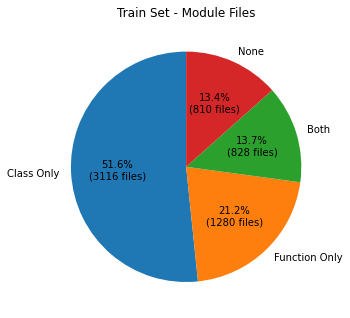

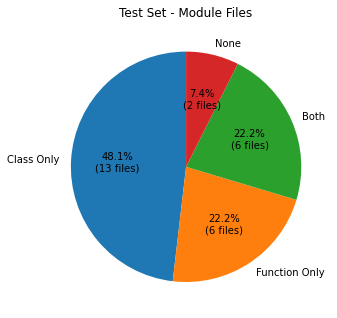

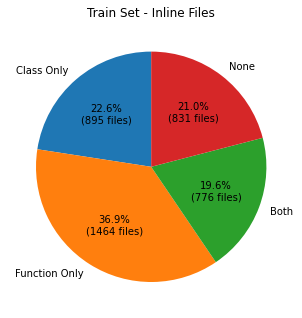

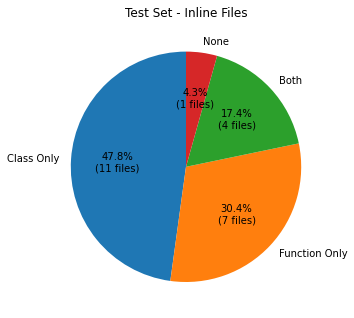

In [21]:
def module_pie(df, title):
    class_only = df[(df['root_class_count'] > 0) & (df['root_function_count'] == 0)]
    func_only = df[(df['root_class_count'] == 0) & (df['root_function_count'] > 0)]
    class_func_both = df[(df['root_class_count'] > 0) & (df['root_function_count'] > 0)]
    none_class_func = df[(df['root_class_count'] == 0) & (df['root_function_count'] == 0)]

    class_func_both_data = [len(class_only), len(func_only), len(class_func_both), len(none_class_func)]
    class_func_both_data_labels = ['Class Only', 'Function Only', 'Both', 'None']
    
    def fmt_label(pct, count):
        absolute = round(pct / 100.0 * count, 1)
        return "{:1.1f}%\n({:.0f} files)".format(pct, absolute)

    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])
    ax.set_title(title)
    ax.pie(class_func_both_data,labels=class_func_both_data_labels,
            shadow=False, startangle=90, autopct=lambda pct: fmt_label(pct, len(df)))
    
    fig.savefig(f'{title}.png', figsize=(4, 4), dpi=200, bbox_inches='tight')

module_pie(df_train_inline_module[df_train_inline_module['is_inline'] == False], 'Train Set - Module Files')
module_pie(df_test_inline_module[df_test_inline_module['is_inline'] == False], 'Test Set - Module Files')
module_pie(df_train_inline_module[df_train_inline_module['is_inline'] == True], 'Train Set - Inline Files')
module_pie(df_test_inline_module[df_test_inline_module['is_inline'] == True], 'Test Set - Inline Files')